In [57]:
import pandas as pd
import numpy as np
import random
import uuid  # Ajout de l'import uuid pour générer des adresses email uniques

# --- Paramètres Généraux ---
N_RECORDS = 40000
FILENAME = "dataset_revenu_marocains.csv"
RANDOM_SEED = 42 # Pour la reproductibilité
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# --- Définition des Catégories ---
MILIEU_OPTS = ['Urbain', 'Rural']
SEXE_OPTS = ['Homme', 'Femme']
NIVEAU_EDUCATION_OPTS = ['Sans niveau', 'Fondamental', 'Secondaire', 'Supérieur']
ETAT_MATRIMONIAL_OPTS = ['Célibataire', 'Marié', 'Divorcé', 'Veuf']
CSP_OPTS = ['Cadres supérieurs', 'Professions intermédiaires', 'Employés', 'Ouvriers', 'Agriculteurs', 'Inactifs']
REGION_GEO_OPTS = ['Nord', 'Centre', 'Sud', 'Est', 'Ouest']
SECTEUR_EMPLOI_OPTS = ['Public', 'Privé', 'Informel']
OUI_NON_OPTS = ['Oui', 'Non']

# --- Proportions pour la génération (peuvent être ajustées) ---
P_URBAIN = 0.60 # Proportion cible d'urbains (ajustable)
P_RURAL = 1 - P_URBAIN

# --- Fonctions de Génération des Caractéristiques (similaires à v1, avec ajustements si besoin) ---

def generate_age(n):
    return np.random.randint(18, 64, n)

def generate_milieu(n):
    return np.random.choice(MILIEU_OPTS, n, p=[P_URBAIN, P_RURAL])

def generate_sexe(n):
    return np.random.choice(SEXE_OPTS, n, p=[0.52, 0.48])

def generate_niveau_education(n):
    return np.random.choice(NIVEAU_EDUCATION_OPTS, n, p=[0.15, 0.30, 0.35, 0.20]) # Un peu plus de 'Supérieur'

def generate_annees_experience(age, niveau_education):
    experience = []
    for a, edu in zip(age, niveau_education):
        min_age_travail = 18
        if edu == 'Supérieur': min_age_travail = 23
        elif edu == 'Secondaire': min_age_travail = 20
        
        max_exp = a - min_age_travail
        if max_exp < 0: max_exp = 0
        
        exp = np.random.randint(0, max_exp + 1) if max_exp > 0 else 0
        exp = min(exp, a - 16) if a > 16 else 0
        experience.append(max(0,exp))
    return np.array(experience)

def generate_etat_matrimonial(n, age):
    etats = []
    for a in age:
        if a < 25: etats.append(np.random.choice(ETAT_MATRIMONIAL_OPTS, p=[0.8, 0.15, 0.03, 0.02]))
        elif a < 45: etats.append(np.random.choice(ETAT_MATRIMONIAL_OPTS, p=[0.2, 0.65, 0.1, 0.05]))
        else: etats.append(np.random.choice(ETAT_MATRIMONIAL_OPTS, p=[0.1, 0.55, 0.15, 0.2]))
    return np.array(etats)

def generate_csp(niveau_education, annees_experience, age):
    csps = []
    for edu, exp, a in zip(niveau_education, annees_experience, age):
        if exp < 1 and a < 22 and edu in ['Sans niveau', 'Fondamental']: csps.append('Inactifs')
        elif edu == 'Supérieur':
            if exp > 8: csps.append('Cadres supérieurs')
            elif exp > 2: csps.append('Professions intermédiaires')
            else: csps.append(np.random.choice(['Employés', 'Professions intermédiaires'], p=[0.7,0.3]))
        elif edu == 'Secondaire':
            if exp > 12: csps.append('Professions intermédiaires')
            elif exp > 4: csps.append('Employés')
            else: csps.append(np.random.choice(['Ouvriers','Employés'], p=[0.7,0.3]))
        elif edu == 'Fondamental':
            if exp > 8: csps.append('Ouvriers')
            else: csps.append(np.random.choice(['Ouvriers', 'Agriculteurs'], p=[0.6,0.4]))
        else: # Sans niveau
            csps.append(np.random.choice(['Ouvriers', 'Agriculteurs', 'Inactifs'], p=[0.35,0.35,0.3]))
    return np.array(csps)

def generate_possession_biens(n, csp_list, milieu_list):
    prop_immo, veh_motor, terr_agri = [], [], []
    for csp, milieu in zip(csp_list, milieu_list):
        p_immo, p_veh, p_agri = 0.05, 0.05, 0.02
        if csp == 'Cadres supérieurs': p_immo, p_veh = 0.7, 0.8
        elif csp == 'Professions intermédiaires': p_immo, p_veh = 0.5, 0.6
        elif csp == 'Employés': p_immo, p_veh = 0.25, 0.35
        elif csp == 'Ouvriers': p_immo, p_veh = 0.1, 0.15
        elif csp == 'Agriculteurs': p_immo, p_veh, p_agri = 0.3, 0.25, 0.6
        
        if milieu == 'Rural':
            p_veh *= 0.7
            if csp == 'Agriculteurs': p_agri = 0.8
        
        prop_immo.append(np.random.choice(OUI_NON_OPTS, p=[p_immo, 1-p_immo]))
        veh_motor.append(np.random.choice(OUI_NON_OPTS, p=[p_veh, 1-p_veh]))
        terr_agri.append(np.random.choice(OUI_NON_OPTS, p=[p_agri, 1-p_agri]))
    return prop_immo, veh_motor, terr_agri

def generate_region_geographique(n):
    return np.random.choice(REGION_GEO_OPTS, n, p=[0.22, 0.28, 0.15, 0.15, 0.20]) # Nord, Centre, Sud, Est, Ouest

def generate_secteur_emploi(n, csp_list):
    secteurs = []
    for csp in csp_list:
        if csp == 'Inactifs': secteurs.append(np.nan)
        elif csp == 'Agriculteurs': secteurs.append(np.random.choice(['Privé', 'Informel'], p=[0.2,0.8]))
        elif csp in ['Cadres supérieurs', 'Professions intermédiaires']: secteurs.append(np.random.choice(['Public', 'Privé'], p=[0.35, 0.65]))
        elif csp == 'Employés': secteurs.append(np.random.choice(['Public', 'Privé', 'Informel'], p=[0.3, 0.5, 0.2]))
        else: secteurs.append(np.random.choice(['Privé', 'Informel'], p=[0.4, 0.6]))
    return np.array(secteurs)

def generate_revenu_secondaire(n, csp_list):
    probs = []
    for csp in csp_list:
        if csp in ['Cadres supérieurs', 'Professions intermédiaires']: probs.append(0.35)
        elif csp == 'Agriculteurs': probs.append(0.25)
        elif csp == 'Employés': probs.append(0.15)
        else: probs.append(0.05)
    return np.array([np.random.choice(OUI_NON_OPTS, p=[p, 1-p]) for p in probs])

# --- Nouvelle Fonction de Génération du Revenu Annuel ---
def adjust_group_revenus(revenus_group, target_prop, tol=0.01, max_iter=50):
    """
    Applique une transformation puissance sur les revenus du groupe afin que
    la proportion des valeurs inférieures à la moyenne soit proche de target_prop.
    Cette transformation préserve l'ordre (monotone) et devrait conserver les relations.
    """
    b_low, b_high = 0.5, 2.0
    b = 1.0
    for _ in range(max_iter):
        trans = np.power(revenus_group, b)
        new_mean = trans.mean()
        prop = (trans < new_mean).mean()
        if abs(prop - target_prop) < tol:
            return trans
        if prop > target_prop:
            b_high = b
        else:
            b_low = b
        b = (b_low + b_high) / 2.0
    return trans  # Au bout de max_iter

def generate_revenu_annuel(df):
    n = len(df)
    revenus = np.zeros(n)
    
    # Masques pour identifier les milieux
    is_urbain = (df['Milieu'] == 'Urbain').values
    is_rural = (df['Milieu'] == 'Rural').values

    # Paramètres de distribution de base distincts - Réduction des sigmas
    base_revenu_log_mean_urbain = np.log(11000)
    base_revenu_log_sigma_urbain = 0.65 # Réduit par rapport à 0.85
    base_revenu_log_mean_rural = np.log(7000)
    base_revenu_log_sigma_rural = 0.95  # Réduit par rapport à 1.15

    # Génération des revenus de base spécifiques
    if is_urbain.sum() > 0:
        revenus[is_urbain] = np.random.lognormal(mean=base_revenu_log_mean_urbain,
                                                  sigma=base_revenu_log_sigma_urbain,
                                                  size=is_urbain.sum())
    if is_rural.sum() > 0:
        revenus[is_rural] = np.random.lognormal(mean=base_revenu_log_mean_rural,
                                                 sigma=base_revenu_log_sigma_rural,
                                                 size=is_rural.sum())

    # Application des bonus/facteurs
    for i in range(n):
        record = df.iloc[i]
        rev = revenus[i]
        # Niveau d'éducation - impact augmenté
        if record['Niveau_education'] == 'Supérieur':
            rev += 25000 * (1 + 0.15 * record['Annees_experience']) # Augmentation du bonus et de l'effet de l'expérience
        elif record['Niveau_education'] == 'Secondaire':
            rev += 10000 * (1 + 0.1 * record['Annees_experience'])  # Augmentation du bonus
        elif record['Niveau_education'] == 'Fondamental':
            rev += 3000 * (1 + 0.05 * record['Annees_experience']) # Légère augmentation
        else: # Sans niveau
            rev += 750 * (1 + 0.03 * record['Annees_experience'])  # Légère augmentation

        # CSP - facteurs augmentés
        csp_factor = {
            'Cadres supérieurs': 2.5,         # Augmenté
            'Professions intermédiaires': 1.8, # Augmenté
            'Employés': 1.4,                  # Augmenté
            'Ouvriers': 1.0,                  # Ajusté
            'Agriculteurs': 0.9,              # Ajusté
            'Inactifs': 0.3                   # Réduit pour marquer la différence
        }.get(record['CSP'], 1.0)
        rev *= csp_factor

        # Sexe - impact légèrement ajusté pour plus de clarté
        rev *= 1.25 if record['Sexe'] == 'Homme' else 0.90

        # Région - impact maintenu ou légèrement ajusté si nécessaire
        region_factor = {
            'Centre': 1.1, 'Ouest': 1.1, 'Nord': 1.05,
            'Sud': 0.95, 'Est': 0.95
        }.get(record['Region_geographique'], 1.0)
        rev *= region_factor

        # Secteur Emploi - impact ajusté
        if pd.notna(record['Secteur_emploi']) and record['CSP'] != 'Inactifs':
            secteur_factor = {'Public': 1.1, 'Privé': 1.15, 'Informel': 0.85}.get(record['Secteur_emploi'], 1.0) # Ajustement des facteurs
            rev *= secteur_factor
        
        # Revenu Secondaire - impact maintenu
        if record['Revenu_secondaire'] == 'Oui':
            rev += 3000
        revenus[i] = rev

    # Calibration des moyennes par milieu
    df_temp = pd.DataFrame({'rev': revenus, 'Milieu': df['Milieu'].values})
    CIBLE_URBAIN = 26988
    CIBLE_RURAL = 12862
    mean_urbain = df_temp.loc[is_urbain, 'rev'].mean() if is_urbain.sum() > 0 else 1
    mean_rural = df_temp.loc[is_rural, 'rev'].mean() if is_rural.sum() > 0 else 1
    
    if is_urbain.sum() > 0 and mean_urbain > 0 : # Éviter la division par zéro ou NaN
        revenus[is_urbain] *= CIBLE_URBAIN / mean_urbain
    if is_rural.sum() > 0 and mean_rural > 0 : # Éviter la division par zéro ou NaN
        revenus[is_rural] *= CIBLE_RURAL / mean_rural


    # Plafonnement
    revenus = np.clip(revenus, 300, 600000)
    inactifs = (df['CSP'] == 'Inactifs').values
    revenus[inactifs] = np.minimum(revenus[inactifs], 8000)

    # Ajustement des proportions sous la moyenne
    # Vous pouvez moduler ou désactiver cette partie pour observer l'impact sur le R²
    global_target = 0.718
    urbain_target = 0.659
    rural_target = 0.854

    # S'assurer que les sous-groupes ne sont pas vides avant d'appeler adjust_group_revenus
    if revenus.size > 0 :
        revenus = adjust_group_revenus(revenus, global_target)
    if is_urbain.sum() > 0 and revenus[is_urbain].size > 0:
        revenus[is_urbain] = adjust_group_revenus(revenus[is_urbain], urbain_target)
    if is_rural.sum() > 0 and revenus[is_rural].size > 0:
        revenus[is_rural] = adjust_group_revenus(revenus[is_rural], rural_target)


    # Renormalisation des moyennes
    if is_urbain.sum() > 0 and np.mean(revenus[is_urbain]) > 0: # Éviter la division par zéro
        revenus[is_urbain] *= CIBLE_URBAIN / np.mean(revenus[is_urbain])
    if is_rural.sum() > 0 and np.mean(revenus[is_rural]) > 0: # Éviter la division par zéro
        revenus[is_rural] *= CIBLE_RURAL / np.mean(revenus[is_rural])

    # Plafonnement final
    revenus = np.clip(revenus, 300, 600000)
    return revenus

# --- Fonctions pour Imperfections (améliorées) ---
def add_valeurs_manquantes(df, colonnes_pour_nan, p_nan=0.001):
    """Ajoute des valeurs manquantes (NaN) de manière aléatoire dans les colonnes spécifiées."""
    for col in colonnes_pour_nan:
        if col in df.columns:
            mask = np.random.choice([True, False], size=len(df), p=[p_nan, 1-p_nan])
            df.loc[mask, col] = np.nan
    return df

def add_valeurs_aberrantes_age(df, p_aberrant=0.001):
    """Ajoute des valeurs aberrantes dans la colonne 'Age'."""
    n_aberr = int(p_aberrant * len(df))
    valid_indices = df.index.tolist()
    aberr_indices = random.sample(valid_indices, min(n_aberr, len(valid_indices)))
    for idx in aberr_indices:
        df.loc[idx, 'Age'] = np.random.choice([-5, 150])  # Valeurs aberrantes
    return df

def add_valeurs_aberrantes_experience(df, p_aberrant=0.001):
    """Ajoute des valeurs aberrantes dans la colonne 'Annees_experience', en tenant compte de l'âge."""
    n_aberr = int(p_aberrant * len(df))
    valid_indices = df.index.tolist()
    aberr_indices = random.sample(valid_indices, min(n_aberr, len(valid_indices)))
    for idx in aberr_indices:
        age = df.loc[idx, 'Age']
        df.loc[idx, 'Annees_experience'] = age + np.random.randint(10, 30)  # Expérience > Age
    return df

def add_valeurs_aberrantes_possession(df, p_aberrant=0.001):
    """Ajoute des valeurs aberrantes dans les colonnes de possession de biens, en tenant compte de la CSP."""
    n_aberr = int(p_aberrant * len(df))
    valid_indices = df.index.tolist()
    aberr_indices = random.sample(valid_indices, min(n_aberr, len(valid_indices)))
    for idx in aberr_indices:
        csp = df.loc[idx, 'CSP']
        if csp == 'Inactifs':
            df.loc[idx, 'Propriete_immobiliere'] = np.random.choice(['Oui', 'Non'], p=[0.9, 0.1])
            df.loc[idx, 'Vehicule_motorise'] = np.random.choice(['Oui', 'Non'], p=[0.8, 0.2])
            df.loc[idx, 'Terrain_agricole'] = np.random.choice(['Oui', 'Non'], p=[0.1, 0.9])
        elif csp == 'Agriculteurs':
            df.loc[idx, 'Terrain_agricole'] = np.random.choice(['Oui', 'Non'], p=[0.05, 0.95])
    return df

def add_valeurs_aberrantes_revenu(revenus_col, csp_col, p_aberrant=0.0005):
    """Ajoute des valeurs aberrantes dans la colonne 'Revenu_Annuel', en tenant compte de la CSP."""
    n_aberr = int(p_aberrant * len(revenus_col))
    valid_indices = revenus_col[revenus_col.notna()].index.tolist()
    aberr_indices = random.sample(valid_indices, min(n_aberr, len(valid_indices)))
    
    for idx in aberr_indices:
        csp = csp_col.loc[idx]
        if csp == 'Inactifs':
            revenus_col.loc[idx] = np.random.choice([100, 200, 300])
        elif csp == 'Cadres supérieurs':
            revenus_col.loc[idx] = np.random.choice([1000000, 1200000, 1500000])
        elif csp == 'Professions intermédiaires':
            revenus_col.loc[idx] = np.random.choice([600000, 700000])
        elif csp == 'Employés':
            revenus_col.loc[idx] = np.random.choice([400000, 500000])
        elif csp == 'Ouvriers':
            revenus_col.loc[idx] = np.random.choice([200000, 300000])
        elif csp == 'Agriculteurs':
            revenus_col.loc[idx] = np.random.choice([50000, 60000])
        else:
            revenus_col.loc[idx] = np.random.choice([300000, 400000, 500000])
    return revenus_col

# --- Génération du Dataset  ---
def generate_dataset():
    data = pd.DataFrame()

    data['Age'] = generate_age(N_RECORDS)
    data['Milieu'] = generate_milieu(N_RECORDS)
    data['Sexe'] = generate_sexe(N_RECORDS)
    data['Niveau_education'] = generate_niveau_education(N_RECORDS)
    data['Annees_experience'] = generate_annees_experience(data['Age'], data['Niveau_education'])
    data['Etat_matrimonial'] = generate_etat_matrimonial(N_RECORDS, data['Age'])
    data['CSP'] = generate_csp(data['Niveau_education'], data['Annees_experience'], data['Age'])
    
    prop_immo, veh_motor, terr_agri = generate_possession_biens(N_RECORDS, data['CSP'], data['Milieu'])
    data['Propriete_immobiliere'] = prop_immo
    data['Vehicule_motorise'] = veh_motor
    data['Terrain_agricole'] = terr_agri

    data['Region_geographique'] = generate_region_geographique(N_RECORDS)
    data['Secteur_emploi'] = generate_secteur_emploi(N_RECORDS, data['CSP'])
    data['Revenu_secondaire'] = generate_revenu_secondaire(N_RECORDS, data['CSP'])
    
    data['Revenu_Annuel'] = generate_revenu_annuel(data.copy()) # Utilise la nouvelle fonction

    # Imperfections
    cols_with_nan = ['Etat_matrimonial', 'Secteur_emploi', 'Revenu_secondaire', 
                     'Propriete_immobiliere', 'Vehicule_motorise', 'Terrain_agricole',
                     'Annees_experience'] # CSP peut avoir des Inactifs, pas besoin de NaN explicite
    data = add_valeurs_manquantes(data, cols_with_nan, p_nan=0.001)
    
    # Aberrations sur le revenu (après génération et NaN)
    revenu_not_na_mask = data['Revenu_Annuel'].notna()
    data.loc[revenu_not_na_mask, 'Revenu_Annuel'] = add_valeurs_aberrantes_revenu(
        data.loc[revenu_not_na_mask, 'Revenu_Annuel'].copy(),
        data.loc[revenu_not_na_mask, 'CSP'].copy()
    )

    # AJOUT : Aberrations sur d'autres colonnes
    data = add_valeurs_aberrantes_age(data, p_aberrant=0.001)
    data = add_valeurs_aberrantes_experience(data, p_aberrant=0.001)
    data = add_valeurs_aberrantes_possession(data, p_aberrant=0.001)

    # Colonne dérivée utile pour EDA, mais pas pour modélisation directe si Age est déjà là
    bins = [18, 25, 45, 60, 100] # 100 pour couvrir les âges aberrants
    labels = ['Jeune', 'Adulte', 'Senior', 'Âgé']
    data['Categorie_age'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
    
    # Vérification finale de cohérence pour Annees_experience vs Age
    mask_exp_incoherent = data['Annees_experience'] > (data['Age'] - 16)
    data.loc[mask_exp_incoherent, 'Annees_experience'] = (data.loc[mask_exp_incoherent, 'Age'] - 16 - np.random.randint(0,2, size=mask_exp_incoherent.sum())).clip(lower=0)
    
    # S'assurer que les inactifs ont bien un revenu bas ou NaN
    inactifs_mask = data['CSP'] == 'Inactifs'
    if 'Revenu_Annuel' in data.columns:
        data.loc[inactifs_mask & data['Revenu_Annuel'].notna(), 'Revenu_Annuel'] = \
            data.loc[inactifs_mask & data['Revenu_Annuel'].notna(), 'Revenu_Annuel'].apply(lambda x: min(x, 12000))

    # AJOUT: Colonnes Redondantes et Non Pertinentes
    data['Revenu_Mensuel'] = (data['Revenu_Annuel'] / 12).round(2)
    data['Adresse_Email'] = [f"user{uuid.uuid4().hex[:6]}@example.com" for _ in range(N_RECORDS)]
    data['CIN'] = [f"{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(100000,999999)}" for _ in range(N_RECORDS)]

    ordered_columns = [
        'Age', 'Categorie_age', 'Sexe', 'Milieu', 'Region_geographique', 'Etat_matrimonial',
        'Niveau_education', 'Annees_experience', 'CSP', 'Secteur_emploi',
        'Propriete_immobiliere', 'Vehicule_motorise', 'Terrain_agricole',
        'Revenu_secondaire', 'Revenu_Annuel', 'Revenu_Mensuel',  # Ajout de Revenu_Mensuel
        'Adresse_Email', 'CIN'  # Ajout de Adresse_Email et CIN
    ]
    final_columns = [col for col in ordered_columns if col in data.columns]
    missing_cols = [col for col in data.columns if col not in final_columns] # Au cas où
    data = data[final_columns + missing_cols]

    return data

# --- Main Execution ---
if __name__ == "__main__":
    print(f"Génération de {N_RECORDS} enregistrements avec le script ...")
    dataset = generate_dataset()
    
    print("\n--- Statistiques Descriptives du Revenu Annuel  ---")
    print(dataset['Revenu_Annuel'].describe())
    
    # --- Vérification des Contraintes HCP ---
    print("\n--- Vérification des Contraintes Statistiques (Basées sur HCP) ---")
    
    # Revenus moyens globaux et par milieu
    revenu_moyen_global_genere = dataset['Revenu_Annuel'].mean()
    print(f"Revenu Annuel Moyen Global (Généré): {revenu_moyen_global_genere:.0f} DH (Cible HCP: 21949 DH)")

    moyennes_milieu_genere = dataset.groupby('Milieu')['Revenu_Annuel'].mean()
    revenu_moyen_urbain_genere = moyennes_milieu_genere.get('Urbain', np.nan)
    revenu_moyen_rural_genere = moyennes_milieu_genere.get('Rural', np.nan)

    print(f"Revenu Annuel Moyen Urbain (Généré): {revenu_moyen_urbain_genere:.0f} DH (Cible HCP: 26988 DH)")
    print(f"Revenu Annuel Moyen Rural (Généré): {revenu_moyen_rural_genere:.0f} DH (Cible HCP: 12862 DH)")

    # Proportions de revenus inférieurs à la moyenne
    if pd.notna(revenu_moyen_global_genere):
        prop_inf_moy_global = (dataset['Revenu_Annuel'] < revenu_moyen_global_genere).mean() * 100
        print(f"Proportion revenus < moyenne globale (Généré): {prop_inf_moy_global:.1f}% (Cible HCP: 71.8%)")
    else:
        print("Proportion revenus < moyenne globale (Généré): Non calculable (moyenne globale NaN)")

    if pd.notna(revenu_moyen_urbain_genere) and 'Urbain' in moyennes_milieu_genere:
        prop_inf_moy_urbain = (dataset[dataset['Milieu'] == 'Urbain']['Revenu_Annuel'] < revenu_moyen_urbain_genere).mean() * 100
        print(f"Proportion revenus < moyenne urbaine (Généré): {prop_inf_moy_urbain:.1f}% (Cible HCP: 65.9%)")
    else:
        print("Proportion revenus < moyenne urbaine (Généré): Non calculable")
    
    if pd.notna(revenu_moyen_rural_genere) and 'Rural' in moyennes_milieu_genere:
        prop_inf_moy_rural = (dataset[dataset['Milieu'] == 'Rural']['Revenu_Annuel'] < revenu_moyen_rural_genere).mean() * 100
        print(f"Proportion revenus < moyenne rurale (Généré): {prop_inf_moy_rural:.1f}% (Cible HCP: 85.4%)")
    else:
        print("Proportion revenus < moyenne rurale (Généré): Non calculable")

    print("\nMoyennes par CSP (Généré) :")
    print(dataset.groupby('CSP')['Revenu_Annuel'].mean().sort_values(ascending=False))

    print("\nMoyennes par Niveau d'éducation (Généré) :")
    print(dataset.groupby('Niveau_education')['Revenu_Annuel'].mean().sort_values(ascending=False))

    dataset.to_csv(FILENAME, index=False, encoding='utf-8')
    print(f"\nDataset '{FILENAME}' généré avec succès ({len(dataset)} enregistrements).")


Génération de 40000 enregistrements avec le script ...

--- Statistiques Descriptives du Revenu Annuel  ---
count     40000.000000
mean      21505.790212
std       33809.163803
min         200.000000
25%        2211.446624
50%       10500.621766
75%       26107.364841
max      700000.000000
Name: Revenu_Annuel, dtype: float64

--- Vérification des Contraintes Statistiques (Basées sur HCP) ---
Revenu Annuel Moyen Global (Généré): 21506 DH (Cible HCP: 21949 DH)
Revenu Annuel Moyen Urbain (Généré): 27157 DH (Cible HCP: 26988 DH)
Revenu Annuel Moyen Rural (Généré): 13084 DH (Cible HCP: 12862 DH)
Proportion revenus < moyenne globale (Généré): 70.5% (Cible HCP: 71.8%)
Proportion revenus < moyenne urbaine (Généré): 66.0% (Cible HCP: 65.9%)
Proportion revenus < moyenne rurale (Généré): 84.7% (Cible HCP: 85.4%)

Moyennes par CSP (Généré) :
CSP
Cadres supérieurs             107018.361782
Professions intermédiaires     32221.681857
Employés                       16967.253461
Ouvriers             

In [41]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
FILENAME = "dataset_revenu_marocains.csv"
RANDOM_SEED = 42  # Also needed for train_test_split

def load_and_preprocess_data(file_path="dataset_revenu_marocains.csv"):
    """
    Charge et prétraite le dataset pour la modélisation.
    Retourne les ensembles de données et un dictionnaire des objets de prétraitement.
    """
    # 1. Charger le dataset
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Erreur : Le fichier '{file_path}' n'a pas été trouvé.")
        return None, None, None, None, None 
    
    print("Dataset chargé avec succès pour le prétraitement.")

    # 2. Séparer X et y
    if 'Revenu_Annuel' not in df.columns:
        print("Erreur : La colonne 'Revenu_Annuel' (cible) est manquante dans le dataset.")
        return None, None, None, None, None

    y = df['Revenu_Annuel'].copy()
    cols_to_drop_for_X = ['Revenu_Annuel', 'Revenu_Mensuel', 'Adresse_Email', 'CIN', 'Categorie_age']
    X = df.drop(columns=[col for col in cols_to_drop_for_X if col in df.columns], errors='ignore')
    print("Variable cible et caractéristiques séparées.")

    # 3. Diviser en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    print(f"Données divisées : X_train shape {X_train.shape}, X_test shape {X_test.shape}")

    X_train = X_train.copy()
    X_test = X_test.copy()

    # 4. Identifier les types de colonnes originales à partir de X_train
    # Ces listes sont capturées AVANT toute imputation ou transformation des colonnes.
    original_numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    original_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Colonnes numériques originales identifiées : {original_numerical_cols}")
    print(f"Colonnes catégorielles originales identifiées : {original_categorical_cols}")

    # 5. Imputation des valeurs manquantes
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    if original_numerical_cols:
        X_train[original_numerical_cols] = num_imputer.fit_transform(X_train[original_numerical_cols])
        X_test[original_numerical_cols] = num_imputer.transform(X_test[original_numerical_cols])
        print("Imputation des valeurs manquantes numériques terminée (médiane).")

    if original_categorical_cols:
        X_train[original_categorical_cols] = cat_imputer.fit_transform(X_train[original_categorical_cols])
        X_test[original_categorical_cols] = cat_imputer.transform(X_test[original_categorical_cols])
        print("Imputation des valeurs manquantes catégorielles terminée (mode).")

    # 6. Encodage One-Hot des variables catégorielles originales
    train_cols_final_list = [] # Initialiser la liste des colonnes finales
    if original_categorical_cols:
        X_train = pd.get_dummies(X_train, columns=original_categorical_cols, prefix=original_categorical_cols, dummy_na=False)
        X_test = pd.get_dummies(X_test, columns=original_categorical_cols, prefix=original_categorical_cols, dummy_na=False)
        print("Encodage One-Hot terminé.")

        train_cols_final_list = X_train.columns.tolist() # Colonnes après one-hot
        X_test = X_test.reindex(columns=train_cols_final_list, fill_value=0)
        X_train = X_train[train_cols_final_list] # S'assurer de l'ordre et de l'ensemble des colonnes
        print("Colonnes alignées entre les ensembles d'entraînement et de test.")
        print(f"Nouvelles dimensions après encodage : X_train shape {X_train.shape}, X_test shape {X_test.shape}")
    else:
        # S'il n'y a pas de colonnes catégorielles, les colonnes finales sont celles de X_train actuelles
        train_cols_final_list = X_train.columns.tolist()

    # 7. Standardisation des variables numériques originales
    # Les noms des colonnes numériques originales sont préservés après le one-hot encoding des catégorielles.
    scaler = StandardScaler()
    if original_numerical_cols:
        # S'assurer que les colonnes à standardiser sont bien présentes dans X_train (elles devraient l'être)
        cols_to_scale = [col for col in original_numerical_cols if col in X_train.columns]
        if cols_to_scale:
            X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
            X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
            print("Standardisation des colonnes numériques d'origine terminée.")
        else:
            print("Aucune colonne numérique (parmi les originales) à standardiser trouvée dans X_train après encodage.")
            
    # Imputation de y_train et y_test si elles contiennent des NaN
    y_imputer = SimpleImputer(strategy='median')
    if y_train.isnull().any():
        y_train = pd.Series(y_imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten(), name=y_train.name, index=y_train.index)
        print("Imputation des NaN dans y_train terminée.")
    if y_test.isnull().any():
        y_test = pd.Series(y_imputer.transform(y_test.values.reshape(-1, 1)).flatten(), name=y_test.name, index=y_test.index)
        print("Imputation des NaN dans y_test terminée.")

    print("Prétraitement terminé.")
    
    preprocessor_objects = {
        'num_imputer': num_imputer,
        'cat_imputer': cat_imputer,
        'scaler': scaler,
        'train_cols_after_dummies': train_cols_final_list,       # Colonnes finales vues par le modèle
        'original_numerical_cols': original_numerical_cols,     # Colonnes numériques avant toute transfo
        'original_categorical_cols': original_categorical_cols  # Colonnes catégorielles avant toute transfo
    }
    return X_train, X_test, y_train, y_test, preprocessor_objects

if __name__ == "__main__":
    # --- Prétraitement des données ---
    print("\n--- Lancement du Prétraitement des Données ---")
    X_train, X_test, y_train, y_test, preprocessor_objects = load_and_preprocess_data(FILENAME)

    if X_train is not None and preprocessor_objects is not None:
        print("\n--- Informations sur les données prétraitées ---")
        print("X_train shape:", X_train.shape)
        print("X_test shape:", X_test.shape)
        print("y_train shape:", y_train.shape)
        print("y_test shape:", y_test.shape)
        
        print("\nPremières lignes de X_train (après prétraitement):")
        print(X_train.head())
        
        print("\nStatistiques de y_train:")
        print(y_train.describe())

        print("\n--- Composants du préprocesseur sauvegardés ---")
        for key, val in preprocessor_objects.items():
            if hasattr(val, 'shape'):
                 print(f"{key}: type {type(val)}, shape {val.shape if isinstance(val, np.ndarray) else 'N/A'}")
            elif isinstance(val, list):
                 print(f"{key}: type {type(val)}, length {len(val)}, exemple {val[:3] if len(val) > 0 else '[]'}")
            else:
                 print(f"{key}: type {type(val)}")
    else:
        print("Échec du prétraitement des données.")



--- Lancement du Prétraitement des Données ---
Dataset chargé avec succès pour le prétraitement.
Variable cible et caractéristiques séparées.
Données divisées : X_train shape (32000, 13), X_test shape (8000, 13)
Colonnes numériques originales identifiées : ['Age', 'Annees_experience']
Colonnes catégorielles originales identifiées : ['Sexe', 'Milieu', 'Region_geographique', 'Etat_matrimonial', 'Niveau_education', 'CSP', 'Secteur_emploi', 'Propriete_immobiliere', 'Vehicule_motorise', 'Terrain_agricole', 'Revenu_secondaire']
Imputation des valeurs manquantes numériques terminée (médiane).
Imputation des valeurs manquantes catégorielles terminée (mode).
Encodage One-Hot terminé.
Colonnes alignées entre les ensembles d'entraînement et de test.
Nouvelles dimensions après encodage : X_train shape (32000, 36), X_test shape (8000, 36)
Standardisation des colonnes numériques d'origine terminée.
Prétraitement terminé.

--- Informations sur les données prétraitées ---
X_train shape: (32000, 36)
X

In [42]:
# CELLULE 3 : Importations supplémentaires et initialisation pour la modélisation

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# Pour stocker les performances des modèles
model_performance = {}

# Définir une constante pour la reproductibilité si nécessaire dans les modèles
RANDOM_STATE = 42

# Vérifier si les données sont chargées (elles devraient l'être par la cellule précédente)
if 'X_train' not in locals() or \
   'X_test' not in locals() or \
   'y_train' not in locals() or \
   'y_test' not in locals():
    print("ERREUR : Les données X_train, X_test, y_train, y_test ne sont pas chargées.")
    print("Veuillez exécuter la cellule de prétraitement des données (load_and_preprocess_data).")
else:
    print("Données d'entraînement et de test prêtes pour la modélisation.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Données d'entraînement et de test prêtes pour la modélisation.
X_train shape: (32000, 36), y_train shape: (32000,)
X_test shape: (8000, 36), y_test shape: (8000,)



--- 3.1. Entraînement du Modèle de Régression Linéaire ---
Entraînement terminé en 0.04 secondes.

--- Évaluation du Modèle de Régression Linéaire ---
MAE (Mean Absolute Error): 8277.86 DH
RMSE (Root Mean Squared Error): 17899.25 DH
R² (Coefficient de détermination): 0.7254

--- Aperçu des Prédictions vs Valeurs Réelles (Régression Linéaire) ---


,Réel,Prédit_LR
0,300.000000,-4526.168249
1,9514.349720,9788.113257
2,13886.129297,30472.286774
3,12291.185637,11976.754616
4,10524.116430,13288.333891
5,20478.219738,20469.455951
6,6465.972785,21969.395768
7,29689.598439,26515.893361
8,9097.518019,18840.235171
9,107554.335002,112476.603031


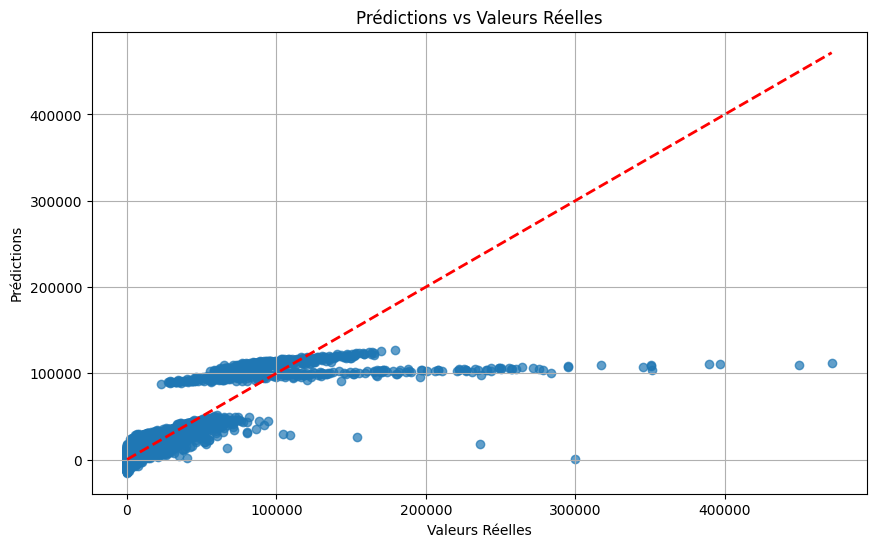

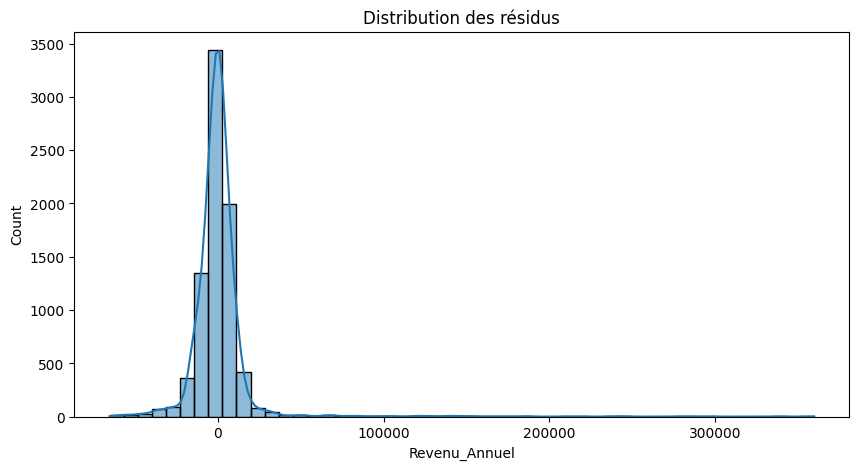

In [32]:
# CELLULE 4 : 3.1. Régression Linéaire (Modèle de Base)

if 'X_train' in locals():
    print("\n--- 3.1. Entraînement du Modèle de Régression Linéaire ---")
    
    # Initialiser et entraîner le modèle
    linear_model = LinearRegression()
    
    start_time_lr = time.time()
    linear_model.fit(X_train, y_train)
    end_time_lr = time.time()
    
    training_time_lr = end_time_lr - start_time_lr
    print(f"Entraînement terminé en {training_time_lr:.2f} secondes.")
    
    # Prédictions
    predictions_lr = linear_model.predict(X_test)
    
    # Évaluation
    mae_lr = mean_absolute_error(y_test, predictions_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
    r2_lr = r2_score(y_test, predictions_lr)
    
    print("\n--- Évaluation du Modèle de Régression Linéaire ---")
    print(f"MAE (Mean Absolute Error): {mae_lr:.2f} DH")
    print(f"RMSE (Root Mean Squared Error): {rmse_lr:.2f} DH")
    print(f"R² (Coefficient de détermination): {r2_lr:.4f}")
    
    # Stocker les performances
    model_performance['Linear Regression'] = {
        'MAE': mae_lr,
        'RMSE': rmse_lr,
        'R2': r2_lr,
        'Training Time (s)': training_time_lr,
        'Best Params': 'N/A'
    }
    
    print("\n--- Aperçu des Prédictions vs Valeurs Réelles (Régression Linéaire) ---")
    df_predictions_lr = pd.DataFrame({'Réel': y_test.values, 'Prédit_LR': predictions_lr})
    display(df_predictions_lr.head(20))
    # Visualisation des résultats
    import matplotlib.pyplot as plt


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions_lr, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Prédictions vs Valeurs Réelles')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Prédictions')
    plt.grid()
    plt.show()
    
    # Calcul des résidus
    residuals = y_test - predictions_lr

    # Visualisation des résidus
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=50)
    plt.title("Distribution des résidus")
    plt.show()
else:
    print("Veuillez d'abord charger et prétraiter les données.")


In [33]:
# CELLULE 5 : 3.2. Arbres de Décision (DecisionTreeRegressor) avec Ajustement des Hyperparamètres

if 'X_train' in locals():
    print("\n--- 3.2. Entraînement et Ajustement des Hyperparamètres pour DecisionTreeRegressor ---")

    # Définir la grille d'hyperparamètres selon les spécifications du projet
    param_grid_dt = {
        'criterion': ['squared_error'], # 'friedman_mse' est aussi une option
        'max_depth': [5],
        'min_samples_split': [2]
    }
    # Note: 'absolute_error' pour criterion peut être significativement plus lent.

    # Initialiser GridSearchCV
    grid_search_dt = GridSearchCV(
        estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
        param_grid=param_grid_dt,
        cv=5, # Nombre de plis pour la validation croisée
        scoring='neg_mean_squared_error', # Métrique pour l'évaluation
        n_jobs=-1, # Utiliser tous les processeurs disponibles
        verbose=1 # Afficher des messages pendant l'ajustement
    )

    print(f"Ajustement des hyperparamètres pour DecisionTreeRegressor en cours (CV={grid_search_dt.cv})...")
    start_time_dt_grid = time.time()
    grid_search_dt.fit(X_train, y_train)
    end_time_dt_grid = time.time()
    grid_search_time_dt = end_time_dt_grid - start_time_dt_grid
    print(f"Ajustement terminé en {grid_search_time_dt:.2f} secondes.")

    # Meilleurs hyperparamètres et score
    print(f"\nMeilleurs hyperparamètres trouvés pour DecisionTreeRegressor : {grid_search_dt.best_params_}")
    # Le best_score_ est neg_mean_squared_error, donc plus proche de 0 est mieux.
    print(f"Meilleur score (neg_mean_squared_error) de validation croisée : {grid_search_dt.best_score_:.4f}")
    
    # Meilleur estimateur
    best_dt_model = grid_search_dt.best_estimator_
    
    # Prédictions sur l'ensemble de test avec le meilleur modèle
    predictions_dt = best_dt_model.predict(X_test)
    
    # Évaluation du meilleur modèle
    mae_dt = mean_absolute_error(y_test, predictions_dt)
    rmse_dt = np.sqrt(mean_squared_error(y_test, predictions_dt))
    r2_dt = r2_score(y_test, predictions_dt)
    
    print("\n--- Évaluation du Modèle DecisionTreeRegressor (avec meilleurs hyperparamètres) ---")
    print(f"MAE: {mae_dt:.2f} DH")
    print(f"RMSE: {rmse_dt:.2f} DH")
    print(f"R²: {r2_dt:.4f}")
    
    # Stocker les performances
    model_performance['Decision Tree (Tuned)'] = {
        'MAE': mae_dt,
        'RMSE': rmse_dt,
        'R2': r2_dt,
        'Training Time (s)': grid_search_time_dt, # Temps pour GridSearchCV
        'Best Params': grid_search_dt.best_params_
    }

    print("\n--- Aperçu des Prédictions vs Valeurs Réelles (Decision Tree) ---")
    df_predictions_dt = pd.DataFrame({'Réel': y_test.values, 'Prédit_DT': predictions_dt})
    display(df_predictions_dt.head(20))
else:
    print("Veuillez d'abord charger et prétraiter les données.")



--- 3.2. Entraînement et Ajustement des Hyperparamètres pour DecisionTreeRegressor ---
Ajustement des hyperparamètres pour DecisionTreeRegressor en cours (CV=5)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Ajustement terminé en 2.86 secondes.

Meilleurs hyperparamètres trouvés pour DecisionTreeRegressor : {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 2}
Meilleur score (neg_mean_squared_error) de validation croisée : -182519938.9769

--- Évaluation du Modèle DecisionTreeRegressor (avec meilleurs hyperparamètres) ---
MAE: 4727.26 DH
RMSE: 10079.37 DH
R²: 0.9129

--- Aperçu des Prédictions vs Valeurs Réelles (Decision Tree) ---


,Réel,Prédit_DT
0,300.000000,596.099256
1,9514.349720,12111.609322
2,13886.129297,15754.871738
3,12291.185637,12111.609322
4,10524.116430,12111.609322
5,20478.219738,22443.513365
6,6465.972785,8848.046563
7,29689.598439,28767.399457
8,9097.518019,5244.809719
9,107554.335002,106612.771653


In [34]:
# CELLULE 7 : 3.3. Forêts Aléatoires (RandomForestRegressor) avec Ajustement des Hyperparamètres

if 'X_train' in locals():
    print("\n--- 3.3. Entraînement et Ajustement des Hyperparamètres pour RandomForestRegressor ---")
    from sklearn.ensemble import RandomForestRegressor

    # Définir une grille d'hyperparamètres plus ciblée pour RandomForest
    # RandomForest peut être long à entraîner avec une grille large.
    param_grid_rf = {
        'n_estimators': [50, 100, 150, 200], # Nombre d'arbres dans la forêt
        'criterion': ['squared_error'], # 'absolute_error' est très lent pour RF, 'friedman_mse' est une alternative
        'max_depth': [None, 5, 10, 15, 20],      # Profondeur max des arbres (similaire à DT)
        # 'min_samples_split': [2, 4], # Nombre min d'échantillons pour diviser un nœud
        # 'min_samples_leaf': [1, 2], # Nombre min d'échantillons par feuille (peut être ajouté)
        # 'max_features': ['sqrt', 'log2'] # Nombre de features à considérer pour la meilleure division (peut être ajouté)
    }
    # Pour un premier essai, cette grille est raisonnable.
    # Si le temps le permet, vous pouvez l'étendre.

    # Initialiser GridSearchCV
    grid_search_rf = GridSearchCV(
        estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1), # n_jobs dans RF pour l'entraînement des arbres
        param_grid=param_grid_rf,
        cv=5, # Réduire le nombre de plis pour accélérer si nécessaire (5 est standard)
        scoring='neg_mean_squared_error',
        n_jobs=-1, # n_jobs dans GridSearchCV pour les plis de CV
        verbose=1
    )

    print(f"Ajustement des hyperparamètres pour RandomForestRegressor en cours (CV={grid_search_rf.cv})...")
    start_time_rf_grid = time.time()
    grid_search_rf.fit(X_train, y_train)
    end_time_rf_grid = time.time()
    grid_search_time_rf = end_time_rf_grid - start_time_rf_grid
    print(f"Ajustement terminé en {grid_search_time_rf:.2f} secondes.")

    # Meilleurs hyperparamètres et score
    print(f"\nMeilleurs hyperparamètres trouvés pour RandomForestRegressor : {grid_search_rf.best_params_}")
    print(f"Meilleur score (neg_mean_squared_error) de validation croisée : {grid_search_rf.best_score_:.4f}")
    
    # Meilleur estimateur
    best_rf_model = grid_search_rf.best_estimator_
    
    # Prédictions
    predictions_rf = best_rf_model.predict(X_test)
    
    # Évaluation
    mae_rf = mean_absolute_error(y_test, predictions_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))
    r2_rf = r2_score(y_test, predictions_rf)
    
    print("\n--- Évaluation du Modèle RandomForestRegressor (avec meilleurs hyperparamètres) ---")
    print(f"MAE: {mae_rf:.2f} DH")
    print(f"RMSE: {rmse_rf:.2f} DH")
    print(f"R²: {r2_rf:.4f}")
    
    # Stocker les performances
    model_performance['Random Forest (Tuned)'] = {
        'MAE': mae_rf,
        'RMSE': rmse_rf,
        'R2': r2_rf,
        'Training Time (s)': grid_search_time_rf,
        'Best Params': grid_search_rf.best_params_
    }

    print("\n--- Aperçu des Prédictions vs Valeurs Réelles (Random Forest) ---")
    df_predictions_rf = pd.DataFrame({'Réel': y_test.values, 'Prédit_RF': predictions_rf})
    display(df_predictions_rf.head(20))

    # Mettre à jour et afficher le tableau comparatif
    print("\n--- Tableau Comparatif des Performances des Modèles (mis à jour) ---")
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
    display(performance_df.sort_values(by='RMSE', ascending=True))

else:
    print("Veuillez d'abord charger et prétraiter les données.")



--- 3.3. Entraînement et Ajustement des Hyperparamètres pour RandomForestRegressor ---
Ajustement des hyperparamètres pour RandomForestRegressor en cours (CV=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Ajustement terminé en 299.41 secondes.

Meilleurs hyperparamètres trouvés pour RandomForestRegressor : {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 150}
Meilleur score (neg_mean_squared_error) de validation croisée : -174539547.7770

--- Évaluation du Modèle RandomForestRegressor (avec meilleurs hyperparamètres) ---
MAE: 4559.19 DH
RMSE: 9648.15 DH
R²: 0.9202

--- Aperçu des Prédictions vs Valeurs Réelles (Random Forest) ---


,Réel,Prédit_RF
0,300.000000,623.364865
1,9514.349720,12131.936537
2,13886.129297,17502.748312
3,12291.185637,12131.936537
4,10524.116430,12131.936537
5,20478.219738,22445.639713
6,6465.972785,8851.974459
7,29689.598439,28811.727105
8,9097.518019,4824.077938
9,107554.335002,106524.976437



--- Tableau Comparatif des Performances des Modèles (mis à jour) ---


,MAE,RMSE,R2,Training Time (s),Best Params
Random Forest (Tuned),4559.192647,9648.150716,0.920211,299.410625,"{'criterion': 'squared_error', 'max_depth': 5,..."
Decision Tree (Tuned),4727.255549,10079.372986,0.912919,2.859078,"{'criterion': 'squared_error', 'max_depth': 5,..."
Linear Regression,8277.856633,17899.248109,0.725384,0.035174,N/A


In [35]:
# CELLULE 8 : 3.4. Gradient Boosting Regressor avec Ajustement des Hyperparamètres

if 'X_train' in locals():
    print("\n--- 3.4. Entraînement et Ajustement des Hyperparamètres pour GradientBoostingRegressor ---")
    from sklearn.ensemble import GradientBoostingRegressor

    # Définir une grille d'hyperparamètres pour GradientBoostingRegressor
    # Gradient Boosting peut aussi être long à entraîner.
    param_grid_gbr = {
        'loss': ['squared_error'], # Ajout de 'absolute_error'
        'n_estimators': [100, 200, 300],          
        'learning_rate': [0.01, 0.1, 0.2],                
        'subsample': [0.5, 0.8, 1.0]            
    }
    # Cette grille est un bon point de départ.

    # Initialiser GridSearchCV
    grid_search_gbr = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
        param_grid=param_grid_gbr,
        cv=3, # Maintenir cv=3 pour la vitesse, augmenter à 5 si le temps le permet
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    print(f"Ajustement des hyperparamètres pour GradientBoostingRegressor en cours (CV={grid_search_gbr.cv})...")
    start_time_gbr_grid = time.time()
    grid_search_gbr.fit(X_train, y_train)
    end_time_gbr_grid = time.time()
    grid_search_time_gbr = end_time_gbr_grid - start_time_gbr_grid
    print(f"Ajustement terminé en {grid_search_time_gbr:.2f} secondes.")

    # Meilleurs hyperparamètres et score
    print(f"\nMeilleurs hyperparamètres trouvés pour GradientBoostingRegressor : {grid_search_gbr.best_params_}")
    print(f"Meilleur score (neg_mean_squared_error) de validation croisée : {grid_search_gbr.best_score_:.4f}")
    
    # Meilleur estimateur
    best_gbr_model = grid_search_gbr.best_estimator_
    
    # Prédictions
    predictions_gbr = best_gbr_model.predict(X_test)
    
    # Évaluation
    mae_gbr = mean_absolute_error(y_test, predictions_gbr)
    rmse_gbr = np.sqrt(mean_squared_error(y_test, predictions_gbr))
    r2_gbr = r2_score(y_test, predictions_gbr)
    
    print("\n--- Évaluation du Modèle GradientBoostingRegressor (avec meilleurs hyperparamètres) ---")
    print(f"MAE: {mae_gbr:.2f} DH")
    print(f"RMSE: {rmse_gbr:.2f} DH")
    print(f"R²: {r2_gbr:.4f}")
    
    # Stocker les performances
    model_performance['Gradient Boosting (Tuned)'] = {
        'MAE': mae_gbr,
        'RMSE': rmse_gbr,
        'R2': r2_gbr,
        'Training Time (s)': grid_search_time_gbr,
        'Best Params': grid_search_gbr.best_params_
    }

    print("\n--- Aperçu des Prédictions vs Valeurs Réelles (Gradient Boosting) ---")
    df_predictions_gbr = pd.DataFrame({'Réel': y_test.values, 'Prédit_GBR': predictions_gbr})
    display(df_predictions_gbr.head(20))

    # Mettre à jour et afficher le tableau comparatif
    print("\n--- Tableau Comparatif des Performances des Modèles (mis à jour) ---")
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
    display(performance_df.sort_values(by='RMSE', ascending=True))

else:
    print("Veuillez d'abord charger et prétraiter les données.")



--- 3.4. Entraînement et Ajustement des Hyperparamètres pour GradientBoostingRegressor ---
Ajustement des hyperparamètres pour GradientBoostingRegressor en cours (CV=3)...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Ajustement terminé en 96.83 secondes.

Meilleurs hyperparamètres trouvés pour GradientBoostingRegressor : {'learning_rate': 0.2, 'loss': 'squared_error', 'n_estimators': 200, 'subsample': 1.0}
Meilleur score (neg_mean_squared_error) de validation croisée : -165911589.2547

--- Évaluation du Modèle GradientBoostingRegressor (avec meilleurs hyperparamètres) ---
MAE: 4074.91 DH
RMSE: 9077.60 DH
R²: 0.9294

--- Aperçu des Prédictions vs Valeurs Réelles (Gradient Boosting) ---


,Réel,Prédit_GBR
0,300.000000,218.091295
1,9514.349720,12691.806495
2,13886.129297,19578.734619
3,12291.185637,12577.625571
4,10524.116430,11362.782487
5,20478.219738,26329.393428
6,6465.972785,13263.125010
7,29689.598439,28911.225569
8,9097.518019,9950.287881
9,107554.335002,106254.450102



--- Tableau Comparatif des Performances des Modèles (mis à jour) ---


,MAE,RMSE,R2,Training Time (s),Best Params
Gradient Boosting (Tuned),4074.908791,9077.601586,0.929368,96.827466,"{'learning_rate': 0.2, 'loss': 'squared_error'..."
Random Forest (Tuned),4559.192647,9648.150716,0.920211,299.410625,"{'criterion': 'squared_error', 'max_depth': 5,..."
Decision Tree (Tuned),4727.255549,10079.372986,0.912919,2.859078,"{'criterion': 'squared_error', 'max_depth': 5,..."
Linear Regression,8277.856633,17899.248109,0.725384,0.035174,N/A


In [36]:
# CELLULE 9 : 3.5. Réseaux de Neurones (MLPRegressor) avec Ajustement des Hyperparamètres

if 'X_train' in locals():
    print("\n--- 3.5. Entraînement et Ajustement des Hyperparamètres pour MLPRegressor ---")
    from sklearn.neural_network import MLPRegressor
    from sklearn.preprocessing import StandardScaler # S'assurer que les données sont bien standardisées pour MLP

    # Note: Les données X_train, X_test devraient déjà être standardisées par preprocess_data_.py
    # Si ce n'était pas le cas, il faudrait le faire ici spécifiquement pour MLP.

    # Définir une grille d'hyperparamètres TRÈS SIMPLE pour MLPRegressor pour un premier essai
    # L'exploration d'architectures de réseau peut être très longue.
    param_grid_mlp = { # Remplacer par la grille simplifiée
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01],
        'max_iter': [300, 500], # S'assurer que early_stopping est activé dans l'estimateur
        # 'batch_size': [32, 64] # Pourrait être testé dans une seconde passe
    }

    grid_search_mlp = GridSearchCV(
        estimator=MLPRegressor(random_state=RANDOM_STATE, early_stopping=True, n_iter_no_change=15, tol=1e-4), # Ajuster n_iter_no_change et tol
        param_grid=param_grid_mlp,
        cv=2, # Maintenir cv=2 ou 3 pour la vitesse
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    print(f"Ajustement des hyperparamètres pour MLPRegressor en cours (CV={grid_search_mlp.cv})...")
    print("Cela peut prendre beaucoup de temps...")
    start_time_mlp_grid = time.time()
    grid_search_mlp.fit(X_train, y_train) # Utiliser X_train_scaled
    end_time_mlp_grid = time.time()
    grid_search_time_mlp = end_time_mlp_grid - start_time_mlp_grid
    print(f"Ajustement terminé en {grid_search_time_mlp:.2f} secondes.")

    # Meilleurs hyperparamètres et score
    print(f"\nMeilleurs hyperparamètres trouvés pour MLPRegressor : {grid_search_mlp.best_params_}")
    print(f"Meilleur score (neg_mean_squared_error) de validation croisée : {grid_search_mlp.best_score_:.4f}")
    
    # Meilleur estimateur
    best_mlp_model = grid_search_mlp.best_estimator_
    
    # Prédictions
    predictions_mlp = best_mlp_model.predict(X_test) # Utiliser X_test_scaled
    
    # Évaluation
    mae_mlp = mean_absolute_error(y_test, predictions_mlp)
    rmse_mlp = np.sqrt(mean_squared_error(y_test, predictions_mlp))
    r2_mlp = r2_score(y_test, predictions_mlp)
    
    print("\n--- Évaluation du Modèle MLPRegressor (avec meilleurs hyperparamètres) ---")
    print(f"MAE: {mae_mlp:.2f} DH")
    print(f"RMSE: {rmse_mlp:.2f} DH")
    print(f"R²: {r2_mlp:.4f}")
    
    # Stocker les performances
    model_performance['MLP Regressor (Tuned)'] = {
        'MAE': mae_mlp,
        'RMSE': rmse_mlp,
        'R2': r2_mlp,
        'Training Time (s)': grid_search_time_mlp,
        'Best Params': grid_search_mlp.best_params_
    }

    print("\n--- Aperçu des Prédictions vs Valeurs Réelles (MLP Regressor) ---")
    df_predictions_mlp = pd.DataFrame({'Réel': y_test.values, 'Prédit_MLP': predictions_mlp})
    display(df_predictions_mlp.head(20))

    # Mettre à jour et afficher le tableau comparatif
    print("\n--- Tableau Comparatif des Performances des Modèles (mis à jour) ---")
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
    display(performance_df.sort_values(by='RMSE', ascending=True))

else:
    print("Veuillez d'abord charger et prétraiter les données.")



--- 3.5. Entraînement et Ajustement des Hyperparamètres pour MLPRegressor ---
Ajustement des hyperparamètres pour MLPRegressor en cours (CV=2)...
Cela peut prendre beaucoup de temps...
Fitting 2 folds for each of 48 candidates, totalling 96 fits
Ajustement terminé en 345.72 secondes.

Meilleurs hyperparamètres trouvés pour MLPRegressor : {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'adam'}
Meilleur score (neg_mean_squared_error) de validation croisée : -155247933.1800

--- Évaluation du Modèle MLPRegressor (avec meilleurs hyperparamètres) ---
MAE: 3603.58 DH
RMSE: 8586.69 DH
R²: 0.9368

--- Aperçu des Prédictions vs Valeurs Réelles (MLP Regressor) ---


,Réel,Prédit_MLP
0,300.000000,824.281373
1,9514.349720,11042.854155
2,13886.129297,21717.191626
3,12291.185637,12010.785864
4,10524.116430,11325.692003
5,20478.219738,23872.599346
6,6465.972785,9369.554706
7,29689.598439,28923.011767
8,9097.518019,8308.298822
9,107554.335002,103591.940735



--- Tableau Comparatif des Performances des Modèles (mis à jour) ---


,MAE,RMSE,R2,Training Time (s),Best Params
MLP Regressor (Tuned),3603.578771,8586.690854,0.936801,345.718267,"{'activation': 'relu', 'alpha': 0.001, 'hidden..."
Gradient Boosting (Tuned),4074.908791,9077.601586,0.929368,96.827466,"{'learning_rate': 0.2, 'loss': 'squared_error'..."
Random Forest (Tuned),4559.192647,9648.150716,0.920211,299.410625,"{'criterion': 'squared_error', 'max_depth': 5,..."
Decision Tree (Tuned),4727.255549,10079.372986,0.912919,2.859078,"{'criterion': 'squared_error', 'max_depth': 5,..."
Linear Regression,8277.856633,17899.248109,0.725384,0.035174,N/A


In [43]:
# CELLULE 6 : Affichage du Tableau Comparatif des Performances

if model_performance:
    print("\n--- Tableau Comparatif des Performances des Modèles ---")
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
    display(performance_df.sort_values(by='RMSE', ascending=True))
else:
    print("Aucun modèle n'a encore été entraîné et évalué.")


Aucun modèle n'a encore été entraîné et évalué.


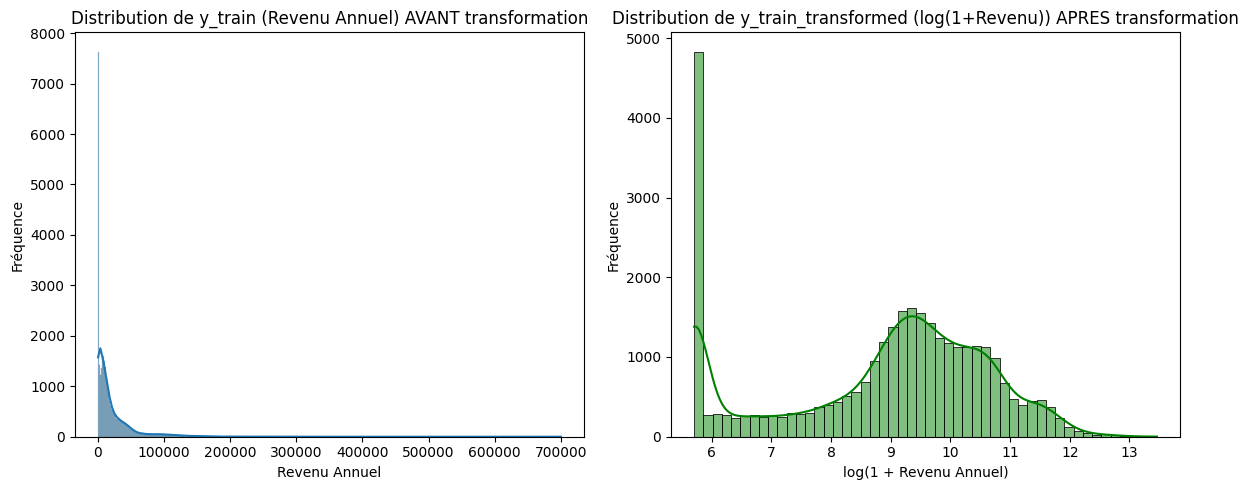


--- Aperçu de y_train_transformed (quelques valeurs) ---
14307     5.707110
17812    10.760685
11020     9.252572
15158    11.673500
24990     9.281263
Name: Revenu_Annuel, dtype: float64


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation de la distribution de y_train AVANT transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title("Distribution de y_train (Revenu Annuel) AVANT transformation")
plt.xlabel("Revenu Annuel")
plt.ylabel("Fréquence")

# Application de la transformation log1p
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)

# Visualisation de la distribution de y_train APRES transformation
plt.subplot(1, 2, 2)
sns.histplot(y_train_transformed, kde=True, color='green')
plt.title("Distribution de y_train_transformed (log(1+Revenu)) APRES transformation")
plt.xlabel("log(1 + Revenu Annuel)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

print("\n--- Aperçu de y_train_transformed (quelques valeurs) ---")
print(y_train_transformed.head())

In [46]:

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import time

# Constants
RANDOM_STATE = 42

# Ensure the CustomPreprocessor class definition is REMOVED from this cell if it was present.

def create_best_mlp(X_train, y_train, X_test, y_test, preprocessor_objects_dict):
    """
    Create and evaluate MLP model with known best parameters.
    preprocessor_objects_dict should contain all necessary fitted preprocessing components
    and lists of original numerical/categorical column names, and final training column names.
    """
    
    print("\n=== Creating MLP Regressor with Best Known Parameters ===")
    
    # Use your previously determined best parameters
    best_params = {
        'hidden_layer_sizes': (100, 100),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.001,
        'learning_rate_init': 0.01,
        'max_iter': 300,
        'early_stopping': True,
        'random_state': RANDOM_STATE,
        'n_iter_no_change': 15,
        'tol': 1e-4,
        'batch_size': 128
    }
    
    # Initialize and train MLP with best parameters
    print("Training MLP with best parameters...")
    start_time = time.time()
    best_mlp = MLPRegressor(**best_params)
    best_mlp.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate on test set
    y_pred = best_mlp.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("\n=== Model Performance ===")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Test MAE: {mae:.2f} DH")
    print(f"Test RMSE: {rmse:.2f} DH")
    print(f"Test R²: {r2:.4f}")
    
    # Save the model along with the dictionary of preprocessor components
    # X_train.columns.tolist() provides the list of feature names as seen by the model during training
    save_model(best_mlp, preprocessor_objects_dict, X_train.columns.tolist(), 
               {'MAE': mae, 'RMSE': rmse, 'R2': r2}, best_params)
    
    return best_mlp


def save_model(model, preprocessor_components_dict, trained_feature_names, metrics, best_params):
    """
    Save the trained model with all necessary preprocessing components (as a dictionary)
    and metadata.
    """
    model_data = {
        'model': model,
        'preprocessor_components': preprocessor_components_dict, # Store the dictionary of components
        'metadata': {
            'performance': metrics,
            'trained_feature_names': trained_feature_names, # List of column names after all preprocessing
            'best_params': best_params,
            'timestamp': pd.Timestamp.now().isoformat()
        }
    }
    
    joblib.dump(model_data, 'best_mlp_model.pkl')
    print("\nModel saved as 'best_mlp_model.pkl'")


# Main execution
# Ensure 'preprocessor_objects' (the dictionary from load_and_preprocess_data) is available
# and correctly populated with all required keys.
if 'X_train' in locals() and 'y_train' in locals() and \
   'X_test' in locals() and 'y_test' in locals() and \
   'preprocessor_objects' in locals(): # preprocessor_objects is the dictionary
    
    # Ensure preprocessor_objects contains all required keys before calling create_best_mlp
    required_keys = ['num_imputer', 'cat_imputer', 'scaler', 'train_cols_after_dummies', 'original_numerical_cols', 'original_categorical_cols']
    if not all(key in preprocessor_objects for key in required_keys):
        print(f"Error: 'preprocessor_objects' dictionary is missing one or more required keys: {required_keys}")
        # Handle error appropriately, e.g., skip model creation or raise an exception
    else:
        best_mlp_model = create_best_mlp(X_train, y_train, X_test, y_test, preprocessor_objects)
        
        sample_preds = pd.DataFrame({
            'Actual': y_test[:20],
            'Predicted': best_mlp_model.predict(X_test[:20]) # X_test is already preprocessed here
        })
        print("\nSample predictions:")
        print(sample_preds)
else:
    print("Error: Required data (X_train, y_train, X_test, y_test, preprocessor_objects) not found. Please run preprocessing first.")



=== Creating MLP Regressor with Best Known Parameters ===
Training MLP with best parameters...

=== Model Performance ===
Training time: 7.86 seconds
Test MAE: 3700.87 DH
Test RMSE: 8620.66 DH
Test R²: 0.9363

Model saved as 'best_mlp_model.pkl'

Sample predictions:
              Actual      Predicted
32823     300.000000     231.569626
16298    9514.349720   11865.465354
28505   13886.129297   21043.544179
6689    12291.185637   12589.964572
26893   10524.116430   12049.775476
36572   20478.219738   25629.749855
12335    6465.972785   10633.396167
29591   29689.598439   30247.819012
18948    9097.518019    7796.122441
31067  107554.335002  104784.035251
22241    6581.648269   11754.743459
13787   56663.949439   54350.273380
5128     9434.254068   12397.241508
9125      356.938119     627.597983
35041   29432.920711   31638.088334
3510      300.000000     231.569626
16441   13684.404515   26055.716632
19463     921.612923    2489.213618
26283    8319.407613   11089.119914
36216    768